# CIFAR10 Dataset Recognition using CNN 
###  → See Section 5 in Master Thesis : "Model prototype" 

## • Imports & preprocessing 

In [112]:
import time 
import numpy as np 
import sys
import matplotlib.pyplot as plt
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten, BatchNormalization, Activation
from keras.layers.convolutional import Conv2D, MaxPooling2D
from keras.constraints import maxnorm
from keras.utils import np_utils
from keras.regularizers import l2
from keras.preprocessing.image import ImageDataGenerator

In [113]:
# Set random seed for purposes of reproducibility
seed = 21

In [114]:
from keras.datasets import cifar10

In [115]:
# loading in the data
     
(X_train, y_train), (X_test, y_test) = cifar10.load_data()

In [116]:
"""
# plot first few images
for i in range(9):
    # define subplot
    plt.subplot(330 + 1 + i)
    # plot raw pixel data
    plt.imshow(X_train[i])
# show the figure
plt.show()
"""

'\n# plot first few images\nfor i in range(9):\n    # define subplot\n    plt.subplot(330 + 1 + i)\n    # plot raw pixel data\n    plt.imshow(X_train[i])\n# show the figure\nplt.show()\n'

In [117]:
# normalize the inputs from 0-255 to between 0 and 1 by dividing by 255
    
X_train = X_train.astype('float32')
X_test = X_test.astype('float32')
X_train = X_train / 255.0
X_test = X_test / 255.0

In [118]:
# Delete some training images to test faster 
X_train_bis = X_train[0:1000] 
y_train_bis = y_train[0:1000]

###  One hot encoding

In [119]:
# specify the number of classes that are in the dataset, so we know how many neurons to compress the final layer down to 
y_train = np_utils.to_categorical(y_train)
y_test = np_utils.to_categorical(y_test)
class_num = y_test.shape[1]

## • Creating the model

### Convolutional layers

In [120]:
# Create the model and add the first convolutional layer 
model = Sequential()

# Add weight decay => add kernel_regularizer=l2(0.001) as parameter and comment Dropout lines 

model.add(Conv2D(32, (3, 3), input_shape=X_train.shape[1:], padding='same')) # 32 filters, window of 3x3 pixels
model.add(Activation('relu')) ### ----------> Tester une autre fonction 

In [121]:
# Dropout ? https://medium.com/@amarbudhiraja/https-medium-com-amarbudhiraja-learning-less-to-learn-better-dropout-in-deep-machine-learning-74334da4bfc5
# It means that you randomly select 20% (if dropout = 0.2) of the neurons and set their weights to zero for the forward and backward passes i.e. for one iteration.
model.add(Dropout(0.2)) 

# Batch normalization:  https://towardsdatascience.com/batch-normalization-in-neural-networks-1ac91516821c 
model.add(BatchNormalization())

In [122]:
# Repeat until 128 
model.add(Conv2D(64, (3, 3), padding='same'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Activation('relu'))
model.add(Dropout(0.2))
model.add(BatchNormalization())

model.add(Conv2D(128, (3, 3), padding='same'))
model.add(Activation('relu'))
model.add(Dropout(0.2))
model.add(BatchNormalization())

### Flatten

In [123]:
model.add(Flatten())
model.add(Dropout(0.2))

### Dense layers

In [124]:
model.add(Dense(256, kernel_constraint=maxnorm(3)))
model.add(Activation('relu'))
model.add(Dropout(0.2))
model.add(BatchNormalization())

model.add(Dense(128, kernel_constraint=maxnorm(3)))
model.add(Activation('relu'))
model.add(Dropout(0.2))
model.add(BatchNormalization())

In [125]:
# Last layer : 10 neurons representing 10 possible outputs 
model.add(Dense(class_num))
model.add(Activation('softmax'))

## • Model compilation

In [126]:
epochs = 10 # https://datascience.stackexchange.com/questions/27561/can-the-number-of-epochs-influence-overfitting
batch_size = 64
optimizer = 'rmsprop' # https://www.quora.com/How-do-I-choose-an-optimizer-for-my-tensorflow-model 

model.compile(loss='categorical_crossentropy', optimizer=optimizer, metrics=['accuracy'])
print(model.summary())

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_16 (Conv2D)           (None, 32, 32, 32)        896       
_________________________________________________________________
activation_31 (Activation)   (None, 32, 32, 32)        0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 32, 32, 32)        0         
_________________________________________________________________
batch_normalization_26 (Batc (None, 32, 32, 32)        128       
_________________________________________________________________
conv2d_17 (Conv2D)           (None, 32, 32, 64)        18496     
_________________________________________________________________
max_pooling2d_6 (MaxPooling2 (None, 16, 16, 64)        0         
_________________________________________________________________
activation_32 (Activation)   (None, 16, 16, 64)        0         
__________

## • Data augmentation

<b>Note:</b> Uncomment this following cell to try some data augmentation and comment the case "Model training" 

In [127]:
'''
# create data generator
datagen = ImageDataGenerator(width_shift_range=0.1, height_shift_range=0.1, horizontal_flip=True)
# prepare iterator
it_train = datagen.flow(X_train, y_train, batch_size=64)
# fit model
steps = int(X_train.shape[0] / 64)
start_time = time.time()
history = model.fit_generator(it_train, steps_per_epoch=steps, epochs=epochs, validation_data=(X_test, y_test))
print("--- %s seconds ---" % (time.time() - start_time)) 
'''

'\n# create data generator\ndatagen = ImageDataGenerator(width_shift_range=0.1, height_shift_range=0.1, horizontal_flip=True)\n# prepare iterator\nit_train = datagen.flow(X_train, y_train, batch_size=64)\n# fit model\nsteps = int(X_train.shape[0] / 64)\nstart_time = time.time()\nhistory = model.fit_generator(it_train, steps_per_epoch=steps, epochs=epochs, validation_data=(X_test, y_test))\nprint("--- %s seconds ---" % (time.time() - start_time)) \n'

## • Model training

In [128]:
np.random.seed(seed)
start_time = time.time()
history = model.fit(X_train, y_train, validation_data=(X_test, y_test), epochs=epochs, batch_size=batch_size)
print("--- %s seconds ---" % (time.time() - start_time)) 

Train on 50000 samples, validate on 10000 samples
Epoch 1/10
50000/50000 [==============================] - 441s 9ms/step - loss: 1.3954 - acc: 0.5063 - val_loss: 1.1654 - val_acc: 0.5900
Epoch 2/10
50000/50000 [==============================] - 441s 9ms/step - loss: 0.9516 - acc: 0.6652 - val_loss: 0.9992 - val_acc: 0.6530
Epoch 3/10
50000/50000 [==============================] - 441s 9ms/step - loss: 0.8232 - acc: 0.7138 - val_loss: 1.1093 - val_acc: 0.6221
Epoch 4/10
50000/50000 [==============================] - 454s 9ms/step - loss: 0.7611 - acc: 0.7376 - val_loss: 1.3283 - val_acc: 0.5844
Epoch 5/10
50000/50000 [==============================] - 439s 9ms/step - loss: 0.7197 - acc: 0.7500 - val_loss: 0.9254 - val_acc: 0.6870
Epoch 6/10
50000/50000 [==============================] - 445s 9ms/step - loss: 0.6835 - acc: 0.7627 - val_loss: 0.8943 - val_acc: 0.6922
Epoch 7/10
50000/50000 [==============================] - 431s 9ms/step - loss: 0.6606 - acc: 0.7752 - val_loss: 0.9947 - 

## • Model evaluation

In [129]:
# Model evaluation
_, acc = model.evaluate(X_test, y_test)
print('accuracy > %.3f' % (acc * 100.0))

10000/10000 [==============================] - 15s 2ms/step
accuracy > 74.160


### Results accuracy

<b> Note: </b> These tests are performed over 1 epoch to avoid multiple large execution times. 

#### Testing optimizers :
<i> On 1 epoch, Batch Size = 64 | With dropout of 0.2 </i> 
- Optimizer RMSPROP : <b>67.640%</b>
- Optimizer ADAM : <b>61.710%</b>
- Optimizer SGD : <b>52.850%</b>
- Optimizer ADAGRAD : <b>59.170%</b> 
- Optimizer ADADELTA : <b>64.580%</b> 

### To counter overfitting : 
#### 1. Testing dropout values : 
<i> On 1 epoch, Batch Size = 64 | Optimizer RMSPROP </i> 
- No dropout : <b>61.310%</b> 
- With dropout of 0.1 : <b>63.320%</b>
- With dropout of 0.2 : <b>67.640%</b> 
- With dropout of 0.4 : <b>48.280%</b> 
- With dropout of 0.6 : <b>32.910%</b> 
- Increasing dropout values (0.2 to 0.5) : <b>48.250%</b> 

#### 2. Testing weight decay : 
<i> On 1 epoch, Batch Size = 64 | Optimizer RMSPROP  </i> 
- With weight decay of 0.001 : <b>64.520%</b>
- With weight decay of 0.01 : <b>57.890%</b>

#### 3. Testing simple data augmentation : 
<i> On 1 epoch, Batch Size = 64 | Optimizer RMSPROP  </i> 
- With horizontal flip, minor shifts of the image, and perhaps small zooming : <b>64.420%</b>

## Plots

#### Testing epochs values : 

<i> On 10 epochs, Batch Size = 64 | Dropout = 0.2 | Optimizer RMSPROP </i>

In [130]:
# plot diagnostic learning curves
def summarize_diagnostics_by_epochs(history):
    # summarize history for accuracy
    plt.plot(history.history['acc'])
    plt.plot(history.history['val_acc'])
    plt.title('model accuracy')
    plt.ylabel('accuracy')
    plt.xlabel('epoch')
    plt.legend(['train', 'test'], loc='upper left')
    plt.show()
    # summarize history for loss --> https://ml-cheatsheet.readthedocs.io/en/latest/loss_functions.html
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.title('model loss')
    plt.ylabel('loss')
    plt.xlabel('epoch')
    plt.legend(['train', 'test'], loc='upper left')
    plt.show()

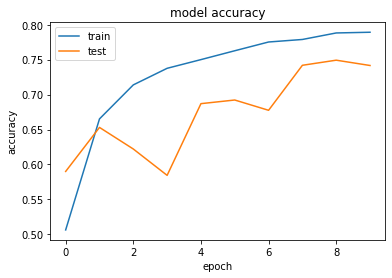

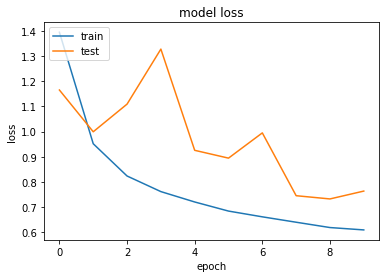

In [131]:
summarize_diagnostics_by_epochs(history)